In [148]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import pydotplus
from IPython.display import Image
from matplotlib.colors import ListedColormap
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA

### Data Preparation

In [149]:
# Load data
data = pd.read_csv('music_spotify.csv')
data.head()

X  acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0  0        0.0102         0.833       204600   0.434          0.021900    2   
1  1        0.1990         0.743       326933   0.359          0.006110    1   
2  2        0.0344         0.838       185707   0.412          0.000234    2   
3  3        0.6040         0.494       199413   0.338          0.510000    5   
4  4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062               4    0.286   
1    0.1370   -10.401     1       0.0794  160.083               4    0.588   
2    0.1590    -7.148     1       0.2890   75.044               4    0.173   
3    0.0922   -15.236     1       0.0261   86.468               4    0.230   
4    0.4390   -11.648     0       0.0694  174.004               4    0.904   

   target      song_title            artist  
0       1        Mask Off            Future  
1       1         Redbone  Childish Gambino  
2       1    Xanny Family            Future  
3       1  Master Of None       Beach House  
4       1  Parallel Lines       Junior Boys

In [150]:
# Drop unnecessary columns
data = data.drop(columns=["X", "song_title", "artist"])
data.head()

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062               4    0.286   
1    0.1370   -10.401     1       0.0794  160.083               4    0.588   
2    0.1590    -7.148     1       0.2890   75.044               4    0.173   
3    0.0922   -15.236     1       0.0261   86.468               4    0.230   
4    0.4390   -11.648     0       0.0694  174.004               4    0.904   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [151]:
# Convert categorical variables to numeric if required using encoding techniques
data = pd.get_dummies(data, drop_first=True)
data.head()

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062               4    0.286   
1    0.1370   -10.401     1       0.0794  160.083               4    0.588   
2    0.1590    -7.148     1       0.2890   75.044               4    0.173   
3    0.0922   -15.236     1       0.0261   86.468               4    0.230   
4    0.4390   -11.648     0       0.0694  174.004               4    0.904   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [152]:
# Split data into X and y
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1613, 13), (404, 13), (1613,), (404,))

In [153]:
# Train model on training data
tree_clf = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0)

### Complexity-Pruning Trade-off and Pruning

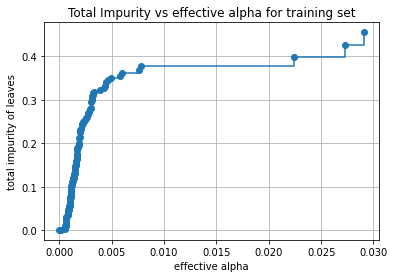

In [154]:
# Compute the cost complexity pruning path for the decision tree classifier
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)

# Extract the effective alphas and the corresponding total leaf impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Compute the cost complexity pruning path again (this line seems to be a duplicate and can be removed)
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)

# Create a new figure and a set of subplots
fig, ax = plt.subplots()

# Plot the effective alphas against the total leaf impurities
# The 'steps-post' drawstyle means that the y value changes after the step
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")

# Set the label for the x-axis
ax.set_xlabel("effective alpha")

# Set the label for the y-axis
ax.set_ylabel("total impurity of leaves")

# Set the title of the plot
ax.set_title("Total Impurity vs effective alpha for training set")

# Add grid lines to the plot
plt.grid()


Text(0, 0.5, 'Accuracy of test set')

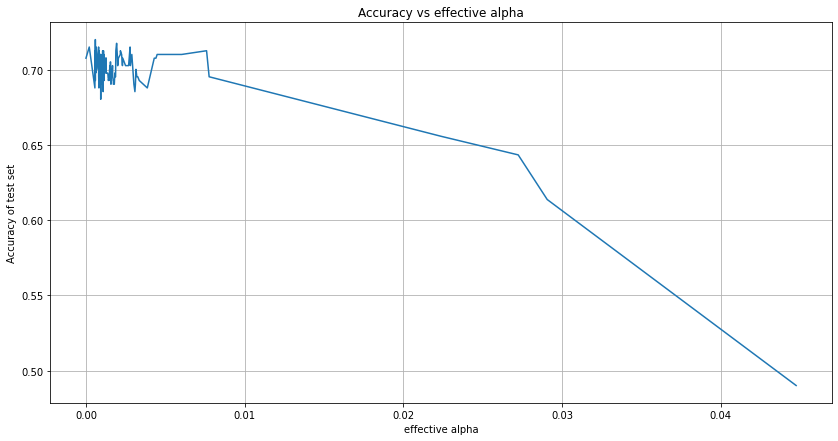

In [155]:
# Initialize empty lists to store ccp_alphas and corresponding accuracy scores
ccp_alphas_collect = []
accuracy_collect = []

# Loop over all ccp_alphas
for ccp_alpha in ccp_alphas:
    # Create a decision tree classifier with the current ccp_alpha
    tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

    # Fit the classifier to the training data
    tree.fit(X_train, y_train)

    # Compute the accuracy of the classifier on the test data
    accuracy = tree.score(X_test, y_test)

    # Append the current ccp_alpha to ccp_alphas_collect
    ccp_alphas_collect.append(ccp_alpha)

    # Append the current accuracy score to accuracy_collect
    accuracy_collect.append(accuracy)
plt.figure(figsize=(14, 7))
plt.plot(np.array(ccp_alphas_collect), np.array(accuracy_collect))
plt.grid()
plt.title("Accuracy vs effective alpha")
plt.xlabel('effective alpha')
plt.ylabel('Accuracy of test set')

### Analysis and Cross-Validation

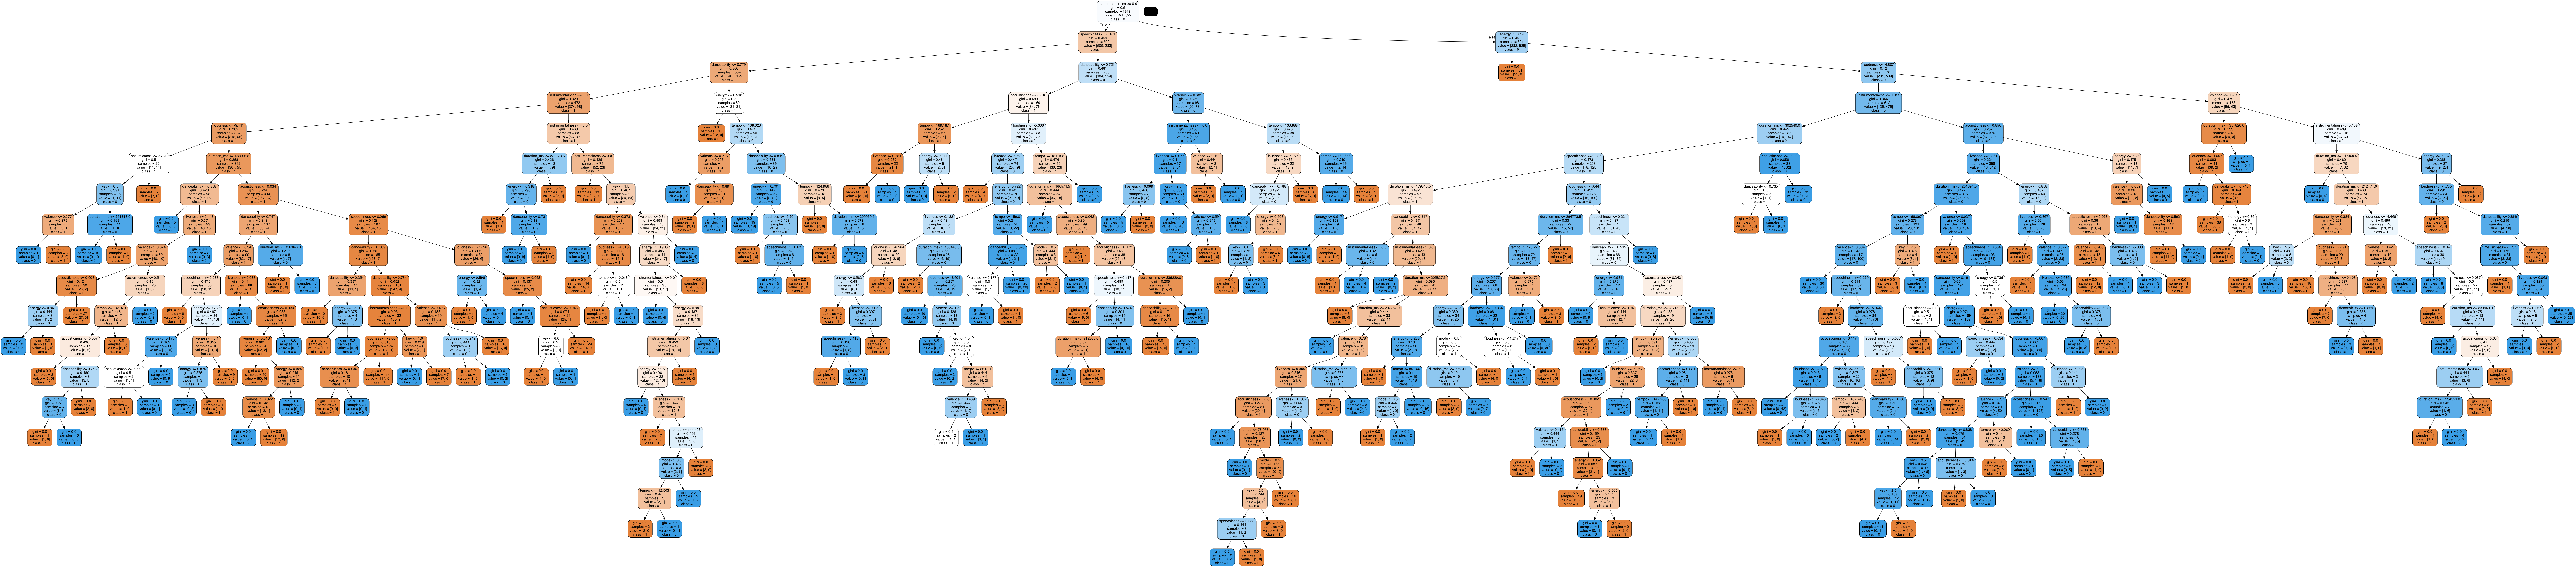

In [156]:
# Plot the decision tree classifier 
unique_classes = data['target'].unique().tolist()
unique_classes = list(map(str, unique_classes))  # Convert integers to strings
# Export the trained decision tree classifier to a tree.dot file
export_graphviz(
    tree_clf,
    out_file="music_spotify.dot",
    feature_names=data.columns[:-1],
    class_names=unique_classes,
    rounded=True,
    filled=True
)
graph = pydotplus.graph_from_dot_file('music_spotify.dot')
Image(graph.create_png())

In [157]:
# Compute the cross-validation score for the decision tree classifier. 
# The scoring metric used is the negative mean squared error, which is why the result is negated.
tree_rmses = -cross_val_score(tree_clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert the array of root mean square errors (RMSEs) to a pandas Series and compute descriptive statistics.
pd.Series(tree_rmses).describe()

count    10.000000
mean      0.324250
std       0.038299
min       0.260870
25%       0.304492
50%       0.319876
75%       0.360076
max       0.372671
dtype: float64

In [158]:
tree_rmses

array([0.28395062, 0.30246914, 0.37037037, 0.32919255, 0.37267081,
       0.37267081, 0.26086957, 0.32298137, 0.31055901, 0.31677019])

### Model Performance and Comparison

In [159]:
# Training the unpruned decision tree classifier
tree_clf = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0)
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0)

In [160]:
# Training the pruned decision tree classifier
pruned_tree_clf = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0.01)
pruned_tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.01)

In [161]:
# Trainin the logistic regression classifier
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


LogisticRegression()

In [162]:
# Making predictions and calculate accuracy
models = [tree_clf, pruned_tree_clf, log_reg]
titles = ["Unpruned Decision Tree", "Pruned Decision Tree", "Logistic Regression"]
for i, model in enumerate(models):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"{titles[i]} - Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

Unpruned Decision Tree - Train Accuracy: 0.9993800371977681, Test Accuracy: 0.7079207920792079
Pruned Decision Tree - Train Accuracy: 0.7321760694358338, Test Accuracy: 0.6955445544554455
Logistic Regression - Train Accuracy: 0.5096094234345939, Test Accuracy: 0.4900990099009901


##### Results expalnation and interpretation:
##### Unpruned Decision Tree
Train Accuracy: Very high (almost 100%).
Test Accuracy: Significantly lower than the training accuracy, at approximately 71%.
Interpretation: The unpruned decision tree is likely overfitting the training data. This is indicated by its nearly perfect performance on the training set but much lower performance on the test set. It has learned the training data too well, including its noise and peculiarities, which does not generalize well to unseen data.

##### Pruned Decision Tree

Train Accuracy: Moderately high, at approximately 73%.
Test Accuracy: Slightly lower than the training accuracy, at about 70%.
Interpretation: The pruned decision tree shows a more balanced performance between the training and test sets, suggesting that pruning helped reduce overfitting. Its test accuracy is close to its training accuracy, which is a sign of good generalization. However, the overall accuracy is not very high, indicating that there might be room for further model optimization or that the decision tree may not be the best model for this specific dataset.

##### Logistic Regression

Train Accuracy: Around 51%.
Test Accuracy: Around 49%.
Interpretation: The logistic regression model shows a consistent performance between training and test sets but with low accuracy in both. This suggests that the model is underfitting the data, meaning it's too simplistic to capture the underlying patterns in the dataset. The logistic regression model might not be complex enough for the data structure, or the features used might not be the most informative for predicting the target variable.


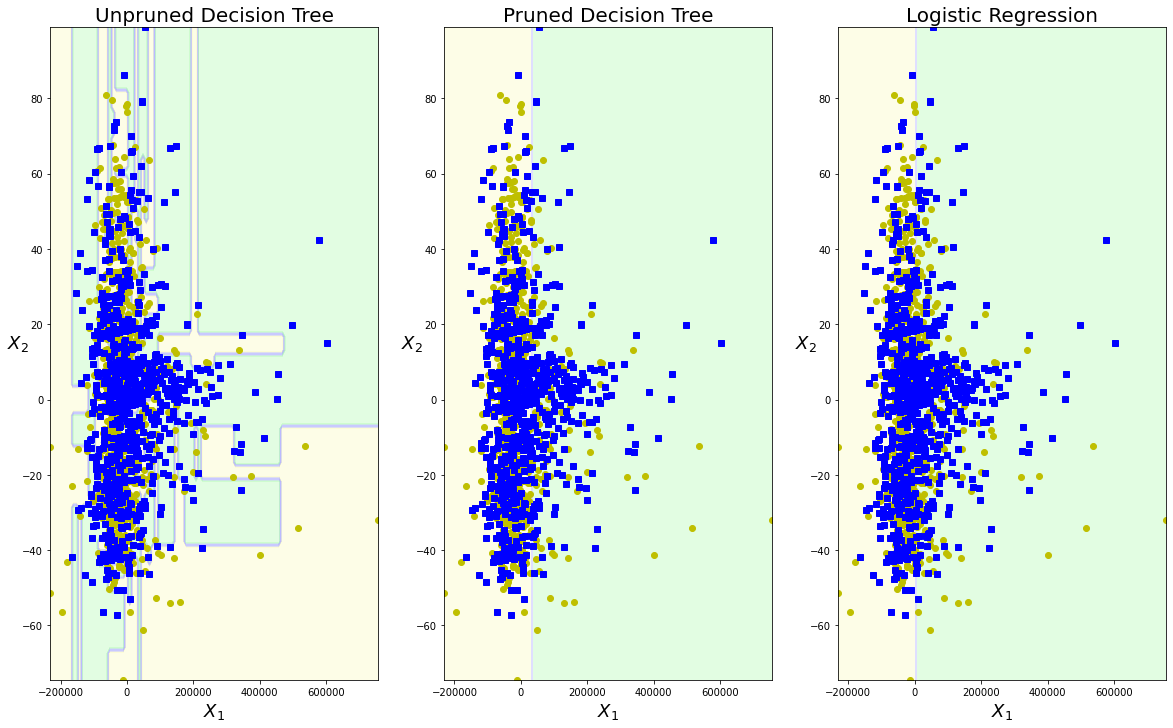

In [163]:
# Define custom colormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Defined models (reinitialize them)
tree_clf = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0)
pruned_tree_clf = DecisionTreeClassifier(min_samples_split=2, ccp_alpha=0.01)
log_reg = LogisticRegression()

# Retrained models on the 2D projected data
tree_clf.fit(X_train_pca, y_train)
pruned_tree_clf.fit(X_train_pca, y_train)
log_reg.fit(X_train_pca, y_train)


# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, axes, cmap=custom_cmap, plot_training=True, resolution=100):
    x1s = np.linspace(axes[0], axes[1], resolution)
    x2s = np.linspace(axes[2], axes[3], resolution)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Class 0")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Class 1")
    plt.axis(axes)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18, rotation=0)


# Plotting decision boundaries
plt.figure(figsize=(20, 12))
models = [tree_clf, pruned_tree_clf, log_reg]
titles = ["Unpruned Decision Tree", "Pruned Decision Tree", "Logistic Regression"]

for i, model in enumerate(models):
    plt.subplot(1, 3, i + 1)
    plot_decision_boundary(model, X_train_pca, y_train,
                           axes=[X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), X_train_pca[:, 1].min(),
                                 X_train_pca[:, 1].max()])
    plt.title(f"{titles[i]}", fontsize=20)

plt.show()
